 # Training a custom MicroYOLO model

In [25]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import itertools
from tqdm import tqdm

Below, we give an example of training a small custom YOLO model on the KITTI dataset. This dataset is designed to classify objects detected with cameras mounted on an autonomous vehicle, though we will use it as a means of detecting objects in urban traffic. You can substitute you own dataset if you like, by writing a class with a similar interface to the one below.
 
 ### Download Dataset:
 Dataset: [Download from Kaggle here](https://www.kaggle.com/twaldo/kitti-object-detection)
 
 ---
 
 The dataset class below has 

100%|██████████| 7481/7481 [00:13<00:00, 551.70it/s]


Classes:  ['Person_sitting', 'Misc', 'Cyclist', 'Tram', 'Pedestrian', 'Car', 'Truck', 'Van']
005916_r
<class 'numpy.ndarray'>
Truck:  [ 79.29095008 207.07555556 140.84225443 230.53603865]


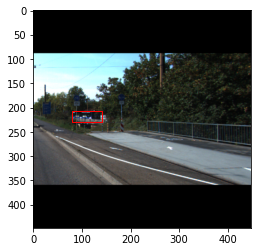

In [2]:
DATASET_DIR = './kitti_single'
IGNORE_LABELS = ['DontCare']

IMG_SIZE = 448
GRID_SIZE = 7
BOXES_PER_GRID = 2
PREDICTIONS_PER_GRID = 20

BATCH_SIZE = 4

class KITTIDataset:
    
    def __init__(self, path, n_items=1000):
        self.path = path
        self.train_x = {} # map of name -> < IMG_SIZE x IMG_SIZE x 3 image>
        self.train_y = {} # map of name -> [(class, (x1,y1,x2,y2)), ...]
        self.train_items = None
        self.classes = None
        
        assert(os.path.isdir(path))
        train_dir = os.path.join(path, 'training/')
        assert(os.path.isdir(train_dir))
        
        # parse labels:
        self.classes = set()
        raw_train_y = self._parse_raw_train_y(
            os.path.join(train_dir,'label_2'), n=n_items)
        for objects in raw_train_y.values():
            for box_class, _ in objects:
                self.classes.add(box_class)
        
        # parse images (split in half due to wide aspect ratio):
        train_x_dir = os.path.join(train_dir,'image_2')
        for f in tqdm(os.listdir(train_x_dir)):
            fpath = os.path.join(train_x_dir, f)
            name = os.path.splitext(f)[0]
            if os.path.isfile(fpath) and name in raw_train_y:
                name_l = name+'_l'
                name_r = name+'_r'
                raw_boxes = raw_train_y[name]
                im_l, b_l, im_r, b_r = self._parse_and_split_img(fpath, raw_boxes)
                self.train_y[name_l] = b_l
                self.train_y[name_r] = b_r
                self.train_x[name_l] = im_l
                self.train_x[name_r] = im_r
                
        assert(len(self.train_x) == len(self.train_y))
        self.train_items = list(self.train_y.keys())
        self.classes = list(self.classes)
        
        
    def _parse_raw_train_y(self, train_y_dir, n):
        train_y = {}
        assert(os.path.isdir(train_y_dir))
        items = os.listdir(train_y_dir)
        for item in items[:min(n,len(items))]:
            item_path = os.path.join(train_y_dir,item)
            if os.path.isfile(item_path):
                name = os.path.splitext(item)[0]
                train_y[name] = self._parse_label(item_path)
        
        return train_y
        
    def _parse_label(self, path):
        assert(os.path.isfile(path))
        objects = []
        with open(path, 'r') as f:
            for line in f.readlines():
                tokens = line.split(' ')
                assert(len(tokens) >= 8)
                name = tokens[0].strip()
                if name not in IGNORE_LABELS:
                    box = np.array([ float(t) for t in tokens[4:8]])
                    objects.append((name, box))
        
        return objects
    
    def _parse_and_split_img(self, path, raw_boxes):
        read_img = cv2.imread(path, cv2.IMREAD_COLOR)
        read_img = cv2.cvtColor(read_img, cv2.COLOR_BGR2RGB)
        # split image in half (aspect ratio is very wide)
        x_mid = read_img.shape[1]//2
        img_l, img_r = read_img[:,:x_mid,:], read_img[:,x_mid:,:]
        boxes_l, boxes_r = [], []
        
        s_l, s_r = max(img_l.shape[0:2]), max(img_r.shape[0:2])
        fl = np.zeros((s_l,s_l,3),np.uint8)
        fr = np.zeros((s_r,s_r,3),np.uint8)
        ax_l,ay_l = (s_l - img_l.shape[1])//2,(s_l - img_l.shape[0])//2
        ax_r,ay_r = (s_r - img_r.shape[1])//2,(s_r - img_r.shape[0])//2
        fl[ay_l:img_l.shape[0]+ay_l,ax_l:ax_l+img_l.shape[1]] = img_l
        fr[ay_r:img_r.shape[0]+ay_r,ax_r:ax_r+img_r.shape[1]] = img_r
        
        fl = cv2.resize(fl, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA)
        fl = np.reshape(fl,(IMG_SIZE,IMG_SIZE,3))
        fr = cv2.resize(fr, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA)
        fr = np.reshape(fr,(IMG_SIZE,IMG_SIZE,3))
        
        for box in raw_boxes:
            center_x = (box[1][0]+box[1][2])/2
            if center_x < x_mid:
                box[1][0] += ax_l
                box[1][2] += ax_l
                box[1][1] += ay_l
                box[1][3] += ay_l
                box[1][:] *= (IMG_SIZE/s_l)
                boxes_l.append(box)
            else:
                box[1][0] += (ax_r-x_mid)
                box[1][2] += (ax_r-x_mid)
                box[1][1] += ay_r
                box[1][3] += ay_r
                box[1][:] *= (IMG_SIZE/s_r)
                boxes_r.append(box)
        
        return fl, boxes_l, fr, boxes_r
    
    def show_example(self):
        name = random.choice(self.train_items)
        print(name)
        img = self.train_x[name]
        boxes = self.train_y[name]
        print(type(img))
        fig, ax = plt.subplots()
        ax.imshow(img.astype(np.uint8))
        for kind, r in boxes:
            print(f'{kind}: ', r)
            rect = patches.Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        plt.show()

kds = KITTIDataset(DATASET_DIR)
print('Classes: ', kds.classes)
kds.show_example()

In [3]:
def grid_box_overlap(box, grid_box):
    int_w = min(box[2], grid_box[2]) - max(box[0],grid_box[0])
    int_h = min(box[3], grid_box[3]) - max(box[1],grid_box[1])
    if int_w <= 0 or int_h <= 0:
        return 0.0
    return 1.0

def boxes_to_output_tensor(objects, img_shape, 
            grid_shape, n_classes, n_boxes, classes):
    assert(len(img_shape) == 3)
    assert(len(grid_shape) == 2)
    grid_h, grid_w = grid_shape
    grid_dy = img_shape[0] / grid_h
    grid_dx = img_shape[1] / grid_w
    n_grid_features = n_classes + 5*n_boxes
    output_tensor = np.zeros((grid_shape[0], grid_shape[1],n_grid_features))
    
    for (name, box) in objects:
        obj_ind = classes.index(name)
        obj_grid_x = int((box[0] + box[2])/(2 * grid_dx))
        obj_cell_x = (box[0] + box[2])/(2 * grid_dx) - obj_grid_x
        obj_grid_y = int((box[1] + box[3])/(2 * grid_dy))
        obj_cell_y = (box[1] + box[3])/(2 * grid_dy) - obj_grid_y
        obj_w = (box[2] - box[0])/img_shape[1]
        obj_h = (box[3] - box[1])/img_shape[0]
        
        # determine the index of the box:
        box_ind = 0
        while box_ind < 1 and \
                output_tensor[obj_grid_y, obj_grid_x, n_classes+5*box_ind+4] <= 0.0:
            box_ind += 1
            
        # add box (if we haven't run out of boxes):
        if box_ind < 1:
            output_tensor[obj_grid_y, obj_grid_x, 5*box_ind:5*(box_ind+1)] = [
                obj_cell_x, obj_cell_y, obj_w, obj_h, 1.0
            ]
    
    return output_tensor

def prepare_data(dataset, holdout=0.2, rand=False):
    data = []
    features_per_grid = 5*BOXES_PER_GRID+PREDICTIONS_PER_GRID
    for item in dataset.train_items:
        x = dataset.train_x[item]
        objects = dataset.train_y[item]
        y = boxes_to_output_tensor(objects, 
                        img_shape=(IMG_SIZE,IMG_SIZE,1),
                        grid_shape=(GRID_SIZE,GRID_SIZE),
                        n_classes=20,
                        n_boxes=2, 
                        classes=dataset.classes)
        data.append((x,y))
    if rand:
        random.shuffle(data)
    hold_ind = int(holdout*len(data))
    return data[hold_ind:], data[:hold_ind]

train_data, test_data = prepare_data(kds)
train_data_x = [ x for x,_ in train_data ]
train_data_y = [ y for _,y in train_data ]
test_data_x = [ x for x,_ in test_data ]
test_data_y = [ y for _,y in test_data ]


In [4]:
class YoloBatcher(keras.utils.Sequence):
    """
        This class will group training instances into batches 
    """
    def __init__(self, images, labels, batch_size) :
        self.images = images
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)

    def __getitem__(self, idx) :
        batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        train_image = []
        train_label = []

        for im, l in zip(batch_x, batch_y):
            train_image.append(im)
            train_label.append(l)
    
        return np.array(train_image), np.array(train_label)
    
train_batcher = YoloBatcher(train_data_x, train_data_y, BATCH_SIZE)
test_batcher = YoloBatcher(test_data_x,test_data_y, BATCH_SIZE)

x_train, y_train = train_batcher.__getitem__(0)
x_test, y_test = test_batcher.__getitem__(0)
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(4, 448, 448, 3)
(4, 7, 7, 30)
(4, 448, 448, 3)
(4, 7, 7, 30)


In [5]:
import tensorflow.keras.backend as K

class YoloReshape(keras.layers.Layer):
    
    def __init__(self, target_shape):
        super(YoloReshape, self).__init__()
        self.target_shape = tuple(target_shape)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'target_shape': self.target_shape
        })
        return config

    def call(self, input):
        # grids 7x7
        S = [self.target_shape[0], self.target_shape[1]]
        # classes
        C = PREDICTIONS_PER_GRID
        # no of bounding boxes per grid
        B = BOXES_PER_GRID
        
        idx1 = S[0] * S[1] * C
        idx2 = idx1 + S[0] * S[1] * B
    
        # class probabilities
        class_probs = K.reshape(input[:, :idx1], (K.shape(input)[0],) + tuple([S[0], S[1], C]))
        class_probs = K.softmax(class_probs)
        
        #confidence
        confs = K.reshape(input[:, idx1:idx2], (K.shape(input)[0],) + tuple([S[0], S[1], B]))
        confs = K.sigmoid(confs)

        # boxes
        boxes = K.reshape(input[:, idx2:], (K.shape(input)[0],) + tuple([S[0], S[1], B * 4]))
        boxes = K.sigmoid(boxes)

        outputs = K.concatenate([class_probs, confs, boxes])
        return outputs

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2

lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

nb_boxes=1
grid_w=7
grid_h=7
cell_w=64
cell_h=64
img_w=grid_w*cell_w
img_h=grid_h*cell_h

model = Sequential()
model.add(Conv2D(filters=64, kernel_size= (7, 7), strides=(1, 1), input_shape =(img_h, img_w, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))
model.add(Conv2D(filters=192, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))
model.add(Conv2D(filters=128, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=1024, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))

model.add(Flatten())
model.add(Dense(512))
model.add(Dense(1024))
model.add(Dropout(0.5))
model.add(Dense(1470, activation='sigmoid'))
model.add(YoloReshape(target_shape=(7,7,30)))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 448, 448, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 192)     110784    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 192)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     24704     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 256)     295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 256)     6

In [7]:
from tensorflow import keras

class CustomLearningRateScheduler(keras.callbacks.Callback):
"""Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.01),
    (2, 0.001),
    (3, 0.0001),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [42]:
import tensorflow.keras.backend as K

def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores


def yolo_head(feats):
    
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh


def yolo_loss(y_true, y_pred):
    
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1

    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2

    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)

    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    box_loss = K.sum(box_loss)

    loss = confidence_loss + class_loss + box_loss

    return loss

def get_yolo_prediction(y_pred, img_shape, confidence_threshold=0.8):
    
    y_pred = K.reshape(y_pred, [1, 7, 7, 20])
    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ?
    
    return predict_xy_min, predict_xy_max
        

In [9]:
# defining a function to save the weights of best model
from tensorflow.keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [10]:
from tensorflow import keras

model.compile(loss=yolo_loss ,optimizer='adam')

In [11]:
model.fit(x=train_batcher,
          steps_per_epoch = int(len(train_data_x) // BATCH_SIZE),
          epochs = 4,
          verbose = 1,
          workers= 4,
          validation_data = test_batcher,
          validation_steps = int(len(test_data_x) // BATCH_SIZE),
           callbacks=[
              CustomLearningRateScheduler(lr_schedule),
              mcp_save
          ])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 100 steps

Epoch 00000: Learning rate is 0.0100.
Epoch 1/4
400/400 [==============================] - 118s 296ms/step - loss: 53.4805 - val_loss: 49.0562

Epoch 00001: Learning rate is 0.0100.
Epoch 2/4
400/400 [==============================] - 113s 282ms/step - loss: 49.0123 - val_loss: 49.0006

Epoch 00002: Learning rate is 0.0010.
Epoch 3/4
400/400 [==============================] - 113s 282ms/step - loss: 49.0005 - val_loss: 49.0004

Epoch 00003: Learning rate is 0.0001.
Epoch 4/4
400/400 [==============================] - 113s 282ms/step - loss: 49.0004 - val_loss: 49.0004


In [43]:
# fetch the first validation example:
x_test, y_test = test_batcher.__getitem__(0)
y_pred = model.predict(x_test)
y_obj = get_yolo_predictions(y_pred)
print(get_yolo_prediction(y_pred, (IMG_SIZE,IMG_SIZE)))
fig, ax = plt.subplots()
ax.imshow(x_test[0].astype(np.uint8))
plt.show()



InvalidArgumentError: Input to reshape is a tensor with 5880 values, but the requested shape has 980 [Op:Reshape]